# LAB 3 PART 1: Assignment 1

Author: Aliprandi Francesco

 <b>NOTE:</b> all the parameter grid both for TDNN and RNN are available in the yaml files inside the grid_param folter

## Temporal Delay NN

### Dataset import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/NARMA10.csv", header=None)
X, Y =  torch.tensor(df.iloc[0]),  torch.tensor(df.iloc[1])

X.shape, Y.shape

(torch.Size([10000]), torch.Size([10000]))

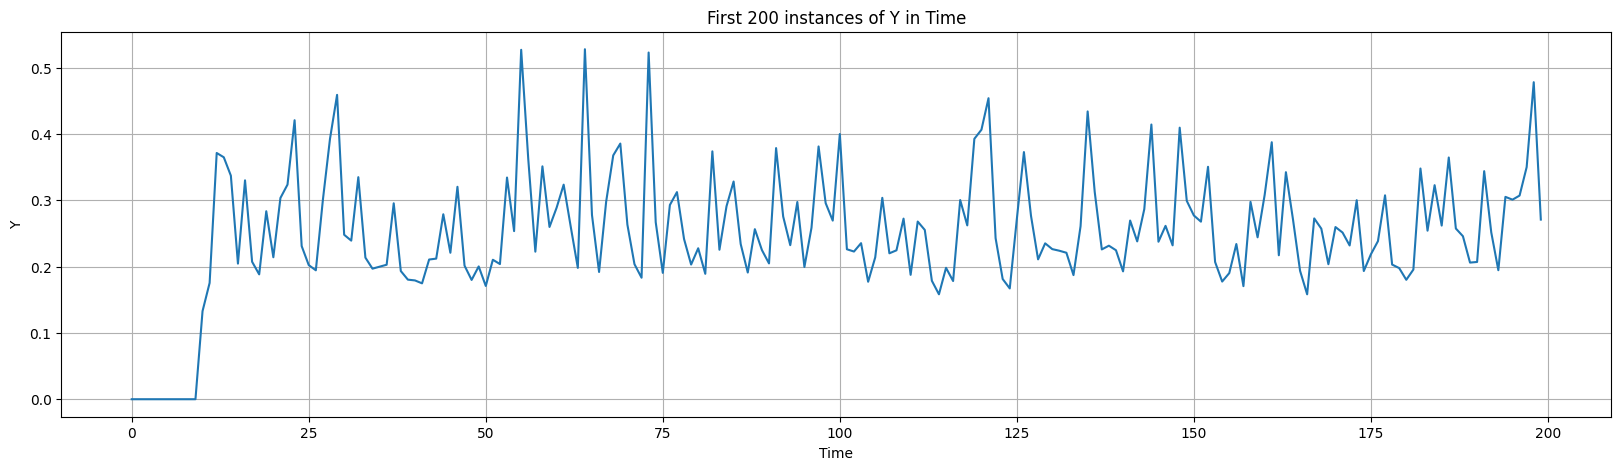

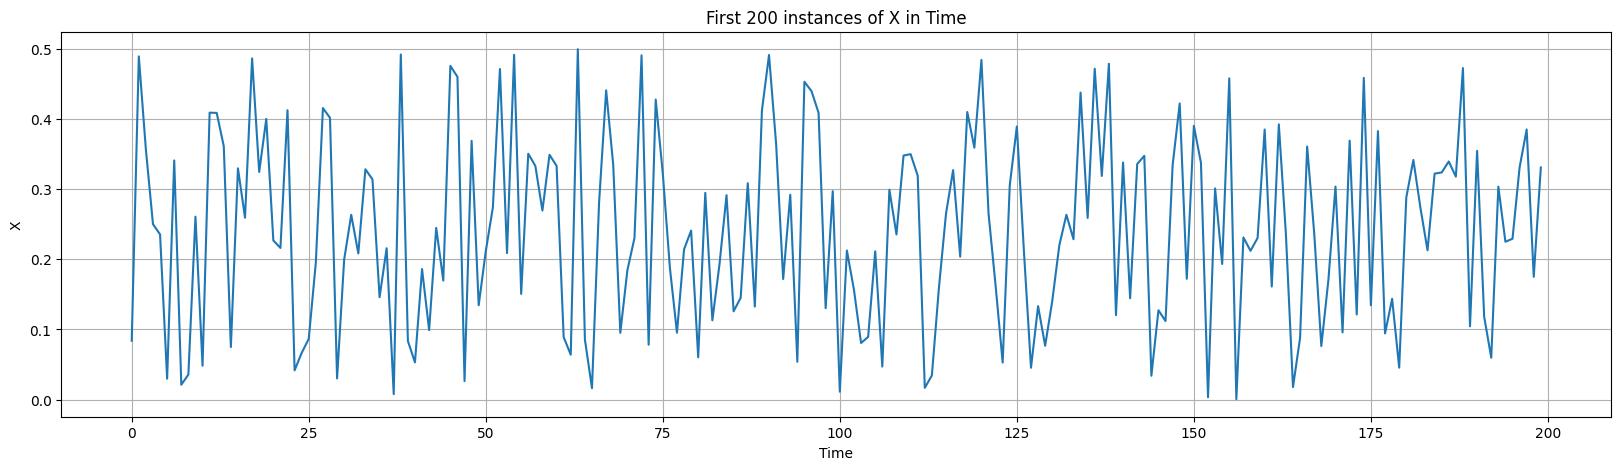

In [2]:
from utils import plot_time_series

time = torch.arange(0, X.shape[0])

plot_time_series(time, Y, "First 200 instances of Y in Time", "Time", "Y", 200)
plot_time_series(time, X, "First 200 instances of X in Time", "Time", "X", 200)
    

### Data Split

In [3]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(1, 1, -1).float()
x_val = x_val.reshape(1, 1, -1).float()
x_test = x_test.reshape(1, 1, -1).float()

y_train = y_train.reshape(1, -1, 1).float()
y_val = y_val.reshape(1, -1, 1).float()
y_test = y_test.reshape(1, -1, 1).float()
    
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([1, 1, 4000])
Validation set shape: torch.Size([1, 1, 1000])
Test set shape: torch.Size([1, 1, 5000])


### Model Assessment

#### Parameters download

In [4]:
from utils import import_parameters

config2, config4 = import_parameters("tdnn2.yaml", "tdnn4.yaml")

#### Model Random Grid Search

In [5]:
from learning import parallel_grid_search

best_model, t_history, v_history, best_params = parallel_grid_search(
    model="TDNN",
    n_iter=500,
    config=(config2, config4),
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    seed=42,
    n_jobs=-1
)

TDNN Grid Search: 100%|██████████| 500/500 [04:11<00:00,  1.98it/s]


Best validation loss: 0.0005645937053486705


In [6]:
print("Best Parameters:")
for key, value in best_params.items():
    print(f" {key}: {value}")

Best Parameters:
 window_sizes: [7, 9]
 hidden_activations: ['Tanh', 'Tanh']
 hidden_layers: [8, 16]
 strides: [1, 1]
 dilations: [1, 4]
 lr: [0.01]
 weight_decay: [0.0001]
 epochs: [350]
 patience: [100]
 delta: ['1e-3']


#### Training and Validation loss

Training Loss: 0.0004010283446405083
Validation Loss: 0.0005645937053486705


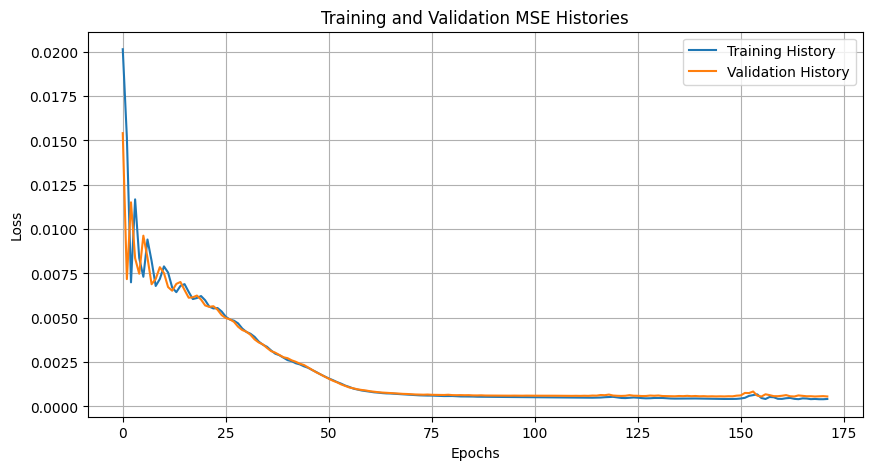

In [7]:
from torch import nn
from utils import plot_histories

train_loss = nn.MSELoss()( best_model.forward(x_train), y_train)
print(f"Training Loss: {train_loss.item()}")

val_loss = nn.MSELoss()( best_model.forward(x_val), y_val)
print(f"Validation Loss: {val_loss.item()}")
plot_histories("tdnn",t_history, v_history)

with open("results/mse.txt", "w") as f:
    f.write("------- TDNN: -------\n\n")
    f.write("Best Parameters:\n")
    for key, value in best_params.items():
        f.write(f" {key}: {value}\n")
    f.write(f"\nTraining Loss: {train_loss.item()}\n")
    f.write(f"Validation Loss: {val_loss.item()}\n")

#### Model Retraining

In [8]:
x_retrain = torch.cat((x_train, x_val), dim=2)
y_retrain = torch.cat((y_train, y_val), dim=1)

ret_history, test_history = best_model.fit(
    x_train = x_retrain,
    y_train = y_retrain,
    x_val = x_test,
    y_val = y_test,
    epochs = int(best_params['epochs'][0]),
    lr = float(best_params['lr'][0]),
    weight_decay = float(best_params['weight_decay'][0]),
    patience = int(best_params['patience'][0]),
    delta = float(best_params['delta'][0]),
    verbose = True,
)

Epoch 50/350, Train Loss: 0.00079091772204265, Val Loss: 0.0006441432051360607
Epoch 100/350, Train Loss: 0.000545305258128792, Val Loss: 0.0004463092191144824
Epoch 150/350, Train Loss: 0.0004949051653966308, Val Loss: 0.0004094750329386443
Early stopping at epoch 150


In [9]:
torch.save(best_model, 'results/tdnn/tdnn.pth')

#### Re-training and Test loss over time plot

Retraining Loss: 0.0004937176709063351
Test Loss: 0.0004094750329386443


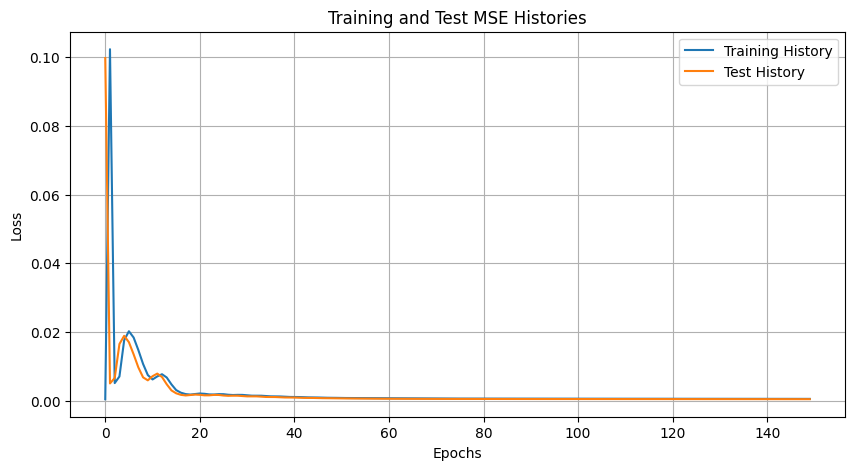

In [10]:
from utils import plot_histories

retrain_loss = nn.MSELoss()(best_model.forward(x_retrain), y_retrain)
print(f"Retraining Loss: {retrain_loss.item()}")

test_loss = nn.MSELoss()(best_model.forward(x_test), y_test)
print(f"Test Loss: {test_loss.item()}")

plot_histories("tdnn",ret_history, test_history, val_set='Test')

with open("results/mse.txt", "w") as f:
    f.write(f"Retraining Loss: {ret_history}\n")
    f.write(f"Test Loss: {test_loss.item()}\n")

#### Target vs Output signal for Training and test set

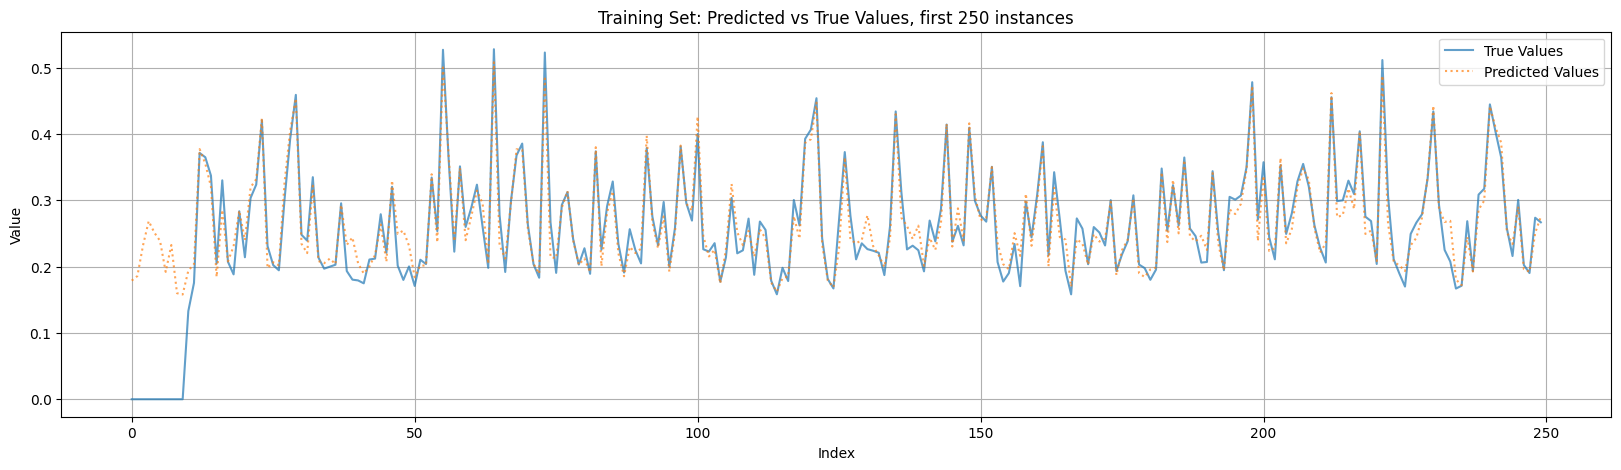

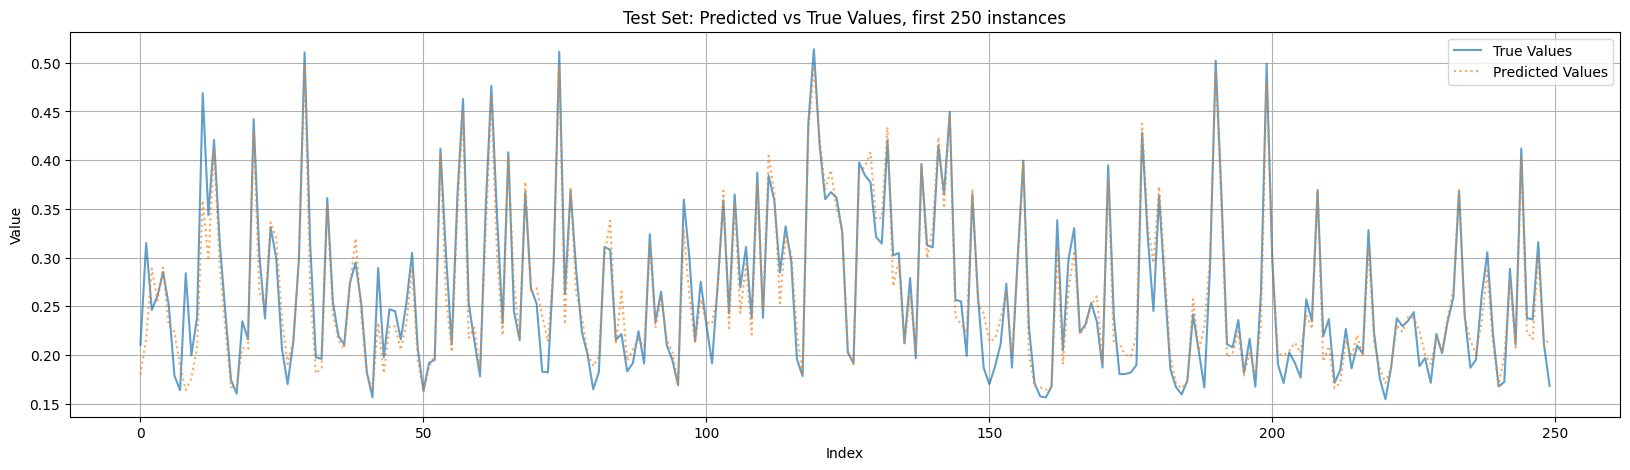

In [11]:
from utils import plot_predictions


y_train_pred = best_model.forward(x_retrain)
plot_predictions(y_train, y_train_pred, "Training Set: Predicted vs True Values, first 250 instances", 250, "tdnn")

y_test_pred = best_model.forward(x_test)
plot_predictions(y_test, y_test_pred, "Test Set: Predicted vs True Values, first 250 instances", 250, "tdnn")


## Recurent Neural Network

### Data Split

In [12]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(-1, 1).float()
x_val = x_val.reshape(-1, 1).float()
x_test = x_test.reshape(-1, 1).float()

y_train = y_train.reshape(-1, 1).float()
y_val = y_val.reshape(-1, 1).float()
y_test = y_test.reshape(-1, 1).float()
    
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([4000, 1])
Validation set shape: torch.Size([1000, 1])
Test set shape: torch.Size([5000, 1])


### Model Assessment

#### Parameters download

In [13]:
from utils import import_parameters

config, _ = import_parameters("rnn.yaml")

#### Model Random Grid Search

In [14]:
from learning import parallel_grid_search

best_model, t_history, v_history, best_params = parallel_grid_search(
    model="RNN",
    n_iter=75,
    config=config,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    seed=42,
    n_jobs=-1
)

RNN Grid Search: 100%|██████████| 75/75 [11:22<00:00,  9.10s/it]


Best validation loss: 0.002268110169097781


In [15]:
print("Best Parameters:")
for key, value in best_params.items():
    print(f" {key}: {value}")

Best Parameters:
 hidden_size: 32
 num_layers: 2
 non_linearity: tanh
 dropout: 0.3
 bidirectional: False
 lr: 0.001
 weight_decay: 0.0001
 epochs: 350
 patience: 30
 delta: 1e-5


#### Training and Validation loss

Training Loss: 0.002183821750804782
Validation Loss: 0.0022947334218770266


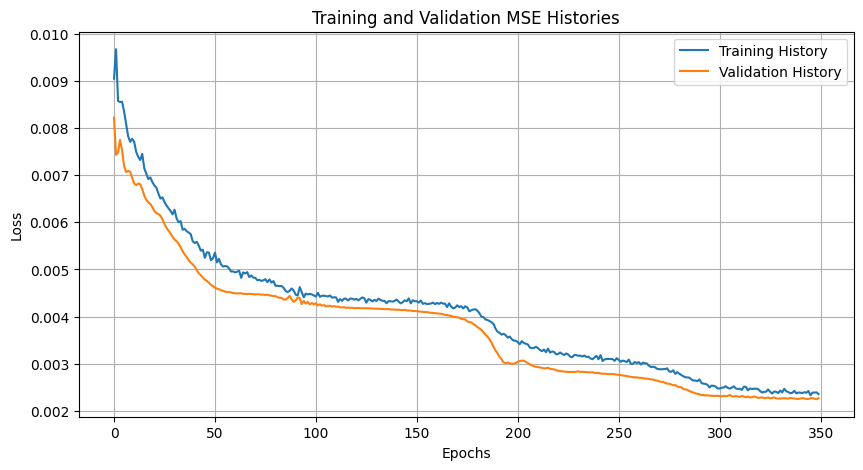

In [16]:
from torch import nn
from utils import plot_histories

train_loss = nn.MSELoss()(best_model.forward(x_train, None)[0], y_train)
print(f"Training Loss: {train_loss.item()}")

val_loss = nn.MSELoss()( best_model.forward(x_val, None)[0], y_val)
print(f"Validation Loss: {val_loss.item()}")
plot_histories("rnn", t_history, v_history)

with open("results/mse.txt", "w") as f:
    f.write("------- RNN: -------\n\n")
    f.write("Best Parameters:\n")
    for key, value in best_params.items():
        f.write(f" {key}: {value}\n")
    f.write(f"\nTraining Loss: {train_loss.item()}\n")
    f.write(f"Validation Loss: {val_loss.item()}\n")

#### Model Retraining

In [17]:
x_retrain = torch.cat((x_train, x_val), dim=0)
y_retrain = torch.cat((y_train, y_val), dim=0)

ret_history, test_history = best_model.fit(
    x_train = x_retrain,
    y_train = y_retrain,
    x_val = x_test,
    y_val = y_test,
    epochs = int(best_params['epochs']),
    lr = float(best_params['lr']),
    weight_decay = float(best_params['weight_decay']),
    patience = int(best_params['patience']),
    delta = float(best_params['delta']),
    verbose = True,
)

Epoch 50/350, Train Loss: 0.0024090949445962906, Val Loss: 0.0020993994548916817
Epoch 100/350, Train Loss: 0.002313289325684309, Val Loss: 0.002049479866400361
Epoch 150/350, Train Loss: 0.0022353280801326036, Val Loss: 0.0019896039739251137
Epoch 200/350, Train Loss: 0.0020147154573351145, Val Loss: 0.0017586026806384325
Epoch 250/350, Train Loss: 0.0019018398597836494, Val Loss: 0.0016614978667348623
Epoch 300/350, Train Loss: 0.0018704361282289028, Val Loss: 0.0016416514990851283
Epoch 350/350, Train Loss: 0.0018197185127064586, Val Loss: 0.0016186120919883251


In [18]:
torch.save(best_model, 'results/rnn/rnn.pth')

#### Re-training and Test loss over time plot

Retraining Loss: 0.0016532810404896736
Test Loss: 0.001618456793949008


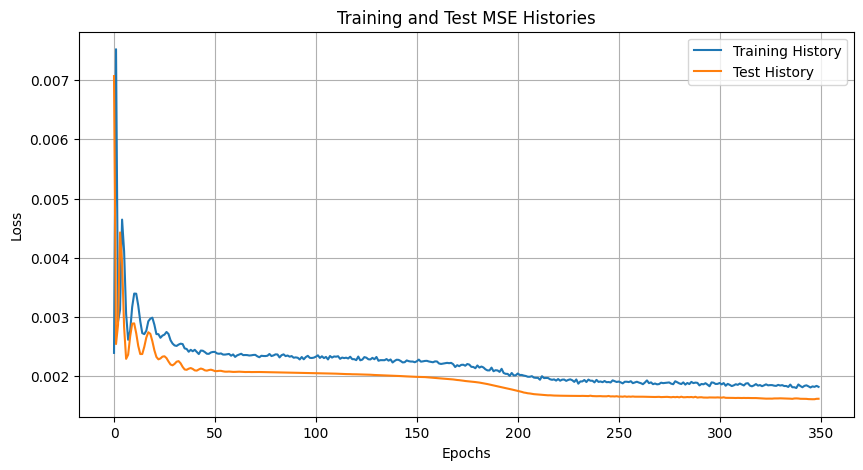

In [19]:
from utils import plot_histories

y_pred, ht = best_model.forward(x_retrain, None)

retrain_loss = nn.MSELoss()(y_pred, y_retrain)
print(f"Retraining Loss: {retrain_loss.item()}")

test_loss = nn.MSELoss()(best_model.forward(x_test, ht)[0], y_test)
print(f"Test Loss: {test_loss.item()}")

plot_histories("rnn", ret_history, test_history, val_set='Test')

with open("results/mse.txt", "w") as f:
    f.write(f"Retraining Loss: {ret_history}\n")
    f.write(f"Test Loss: {test_loss.item()}\n")
    

#### Target vs Output signal for Training and test set

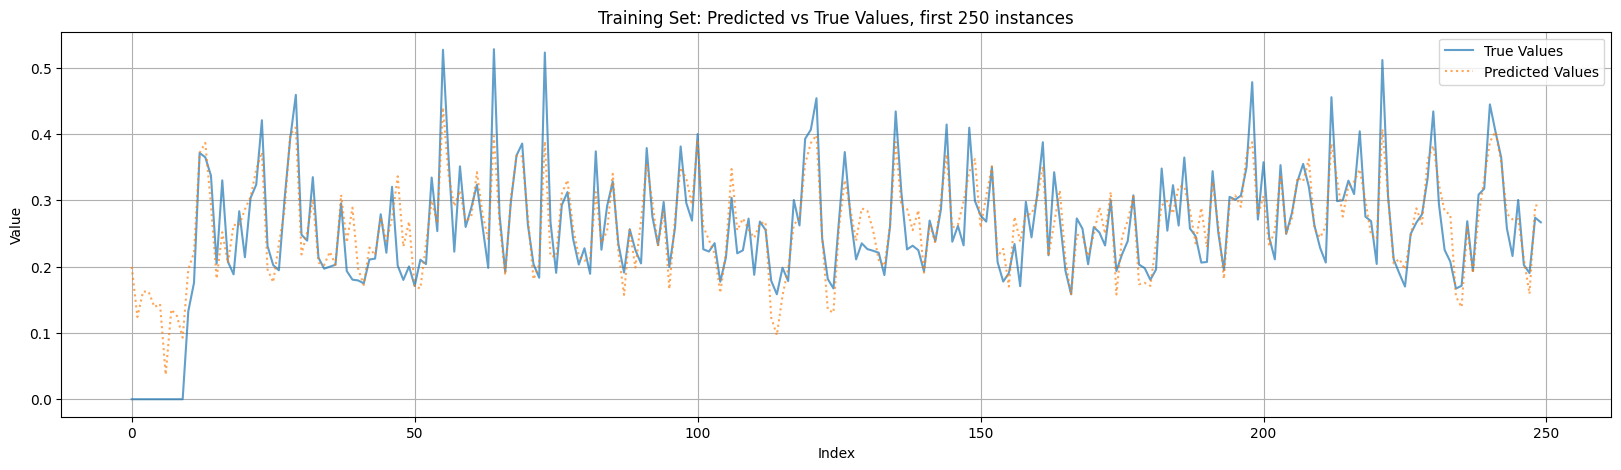

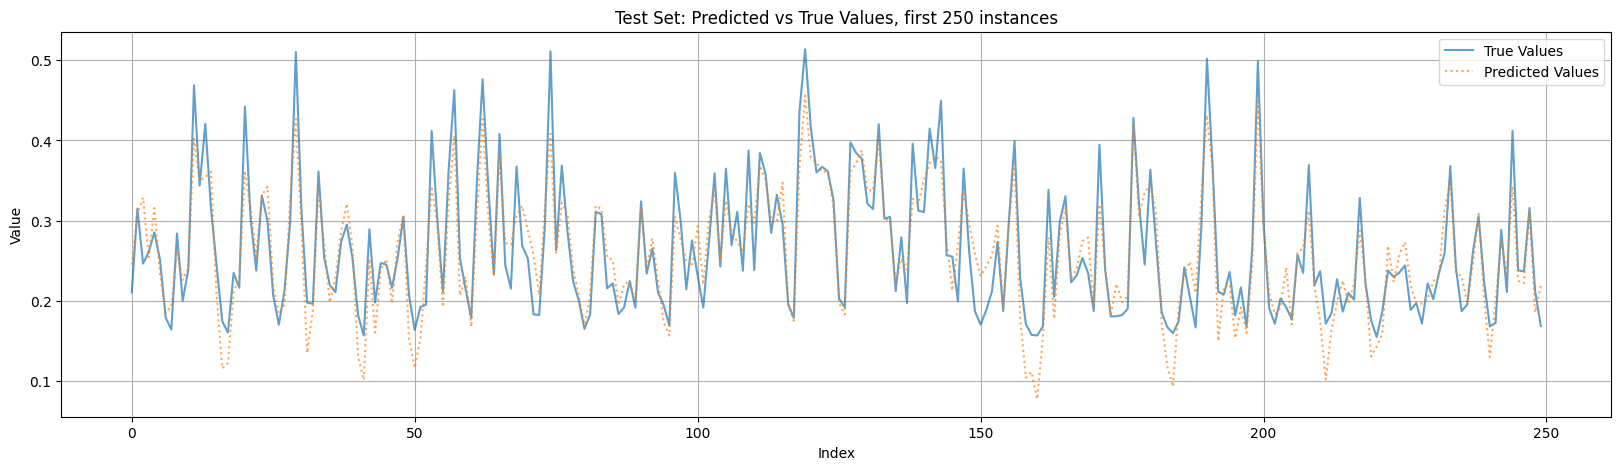

In [20]:
from utils import plot_predictions


y_train_pred, ht = best_model.forward(x_retrain, None)
plot_predictions(y_train, y_train_pred, "Training Set: Predicted vs True Values, first 250 instances", 250, "rnn")

y_test_pred, _ = best_model.forward(x_test, ht)
plot_predictions(y_test, y_test_pred, "Test Set: Predicted vs True Values, first 250 instances", 250, "rnn")
